In [1]:
%matplotlib inline

**Requirements**



In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
from collections import OrderedDict
import unicodedata
import string
import re
import random
import numpy as np
import pickle as pkl
import spacy
nlp = spacy.load('en')

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

use_cuda = torch.cuda.is_available()

**Settings**

In [3]:
ORDER = 2
NUM_WORDS = 10000

###### **Preprocessing Data**

In [4]:
SOS_token = 0
EOS_token = 1

def extract_ngrams(vocab, sent, order):
    ngrams = []
    
    # tokenization
    uwords = [t.text for t in nlp(str(sent))]
    
    # extract ngrams
    for oo in range(1, order + 1):
        for ng in set([' '.join(t).strip() for t in zip(*[uwords[i:] for i in range(oo)])]):
            ngrams.append(ng)
            if ng in vocab:
                vocab[ng] += 1
            else:
                vocab[ng] = 1


    return vocab, ngrams

class Lang:
    def __init__(self, name, order):
        self.name = name
        
        # for single words
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS
        
        # for ngrams
        self.order = order
        self.vocab0 = OrderedDict()

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)
        self.vocab0, ngrams = extract_ngrams(self.vocab0, sentence, self.order)
        return ngrams

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
    
    def createNGramDictionary(self):
        tokens = list(self.vocab0.keys())
        freqs = list(self.vocab0.values())
        sidx = np.argsort(freqs)[::-1]
        vocab = OrderedDict([(tokens[s], i) for i, s in enumerate(sidx)])
        return vocab

In [5]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [6]:
def readLangs(lang1, lang2, order, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2, order)
        output_lang = Lang(lang1, order)
    else:
        input_lang = Lang(lang1, order)
        output_lang = Lang(lang2, order)

    return input_lang, output_lang, pairs

In [7]:
MAX_LENGTH = 7

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [8]:
def prepareData(lang1, lang2, order, reverse=False):
    data = []
    input_lang, output_lang, pairs = readLangs(lang1, lang2, order, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        #input_lang.addSentence(pair[0])
        pair[0] = output_lang.addSentence(pair[1])

    print("Counted words:")
#     print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('eng', 'fra', ORDER, True)
vocab_ngrams = output_lang.createNGramDictionary()
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 5412 sentence pairs
Counting words...
Counted words:
eng 1644
[['he', 'my', '.', 'hero', 's', 'my hero', 'hero .', 'he s', 's my'], 'he s my hero .']


In [9]:
len(vocab_ngrams)

6711

Split the data into training set and test set

In [291]:
random.shuffle(pairs)
print(len(pairs))
train_set = pairs[:5120]
test_set = pairs[5120:]
print(random.choice(train_set))
print(random.choice(test_set))

5412
[['happy', 'more', 'than', '.', 'm', 'i', 'more than', 'm more', 'happy .', 'i m', 'than happy'], 'i m more than happy .']
[['they', 're', 'asleep', '.', 'they re', 'asleep .', 're asleep'], 'they re asleep .']


The Seq2Seq Model
=================

A Recurrent Neural Network, or RNN, is a network that operates on a
sequence and uses its own output as input for subsequent steps.

A `Sequence to Sequence network <http://arxiv.org/abs/1409.3215>`__, or
seq2seq network, or `Encoder Decoder
network <https://arxiv.org/pdf/1406.1078v3.pdf>`__, is a model
consisting of two RNNs called the encoder and decoder. The encoder reads
an input sequence and outputs a single vector, and the decoder reads
that vector to produce an output sequence.

.. figure:: /_static/img/seq-seq-images/seq2seq.png
   :alt:

Unlike sequence prediction with a single RNN, where every input
corresponds to an output, the seq2seq model frees us from sequence
length and order, which makes it ideal for translation between two
languages.

Consider the sentence "Je ne suis pas le chat noir" → "I am not the
black cat". Most of the words in the input sentence have a direct
translation in the output sentence, but are in slightly different
orders, e.g. "chat noir" and "black cat". Because of the "ne/pas"
construction there is also one more word in the input sentence. It would
be difficult to produce a correct translation directly from the sequence
of input words.

With a seq2seq model the encoder creates a single vector which, in the
ideal case, encodes the "meaning" of the input sequence into a single
vector — a single point in some N dimensional space of sentences.




The Encoder
-----------

The encoder of a seq2seq network is a RNN that outputs some value for
every word from the input sentence. For every input word the encoder
outputs a vector and a hidden state, and uses the hidden state for the
next input word.

.. figure:: /_static/img/seq-seq-images/encoder-network.png
   :alt:





In [11]:
# class EncoderRNN(nn.Module):
#     def __init__(self, input_size, hidden_size):
#         super(EncoderRNN, self).__init__()
#         self.hidden_size = hidden_size

#         self.embedding = nn.Embedding(input_size, hidden_size)
#         self.gru = nn.GRU(hidden_size, hidden_size)

#     def forward(self, input, hidden):
#         embedded = self.embedding(input).view(1, 1, -1)
#         output = embedded
#         output, hidden = self.gru(output, hidden)
#         return output, hidden

#     def initHidden(self):
#         result = Variable(torch.zeros(1, 1, self.hidden_size))
#         if use_cuda:
#             return result.cuda()
#         else:
#             return result

class NGramEncoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(NGramEncoder, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
    
    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        hidden = hidden + embedded
        return output, hidden
    
    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

The Decoder
-----------

The decoder is another RNN that takes the encoder output vector(s) and
outputs a sequence of words to create the translation.




Simple Decoder
^^^^^^^^^^^^^^

In the simplest seq2seq decoder we use only last output of the encoder.
This last output is sometimes called the *context vector* as it encodes
context from the entire sequence. This context vector is used as the
initial hidden state of the decoder.

At every step of decoding, the decoder is given an input token and
hidden state. The initial input token is the start-of-string ``<SOS>``
token, and the first hidden state is the context vector (the encoder's
last hidden state).

.. figure:: /_static/img/seq-seq-images/decoder-network.png
   :alt:





In [12]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

I encourage you to train and observe the results of this model, but to
save space we'll be going straight for the gold and introducing the
Attention Mechanism.




Attention Decoder
^^^^^^^^^^^^^^^^^

If only the context vector is passed betweeen the encoder and decoder,
that single vector carries the burden of encoding the entire sentence.

Attention allows the decoder network to "focus" on a different part of
the encoder's outputs for every step of the decoder's own outputs. First
we calculate a set of *attention weights*. These will be multiplied by
the encoder output vectors to create a weighted combination. The result
(called ``attn_applied`` in the code) should contain information about
that specific part of the input sequence, and thus help the decoder
choose the right output words.

.. figure:: https://i.imgur.com/1152PYf.png
   :alt:

Calculating the attention weights is done with another feed-forward
layer ``attn``, using the decoder's input and hidden state as inputs.
Because there are sentences of all sizes in the training data, to
actually create and train this layer we have to choose a maximum
sentence length (input length, for encoder outputs) that it can apply
to. Sentences of the maximum length will use all the attention weights,
while shorter sentences will only use the first few.

.. figure:: /_static/img/seq-seq-images/attention-decoder-network.png
   :alt:





In [13]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH*ORDER):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

# Training

## Preparing Training Data

In [14]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def variableFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    result = Variable(torch.LongTensor(indexes).view(-1, 1))
    if use_cuda:
        return result.cuda()
    else:
        return result


def indexesFromNGramList(vocab, ngram_list, order, num_words):
    result = []
    for ng in ngram_list:
        if ng in vocab:
            idx = vocab[ng]
            if idx > num_words:
                pass
            else:
                result.append(idx)
        else:
            pass
    return result
    
    
def variableFromNGramList(vocab, ngram_list, order, num_words):
    indexes = indexesFromNGramList(vocab, ngram_list, order, num_words)
    result = Variable(torch.LongTensor(indexes).view(-1, 1))
    if use_cuda:
        return result.cuda()
    else:
        return result
    
    
def variablesFromPair(pair):
    input_variable = variableFromNGramList(vocab_ngrams, pair[0], ORDER, NUM_WORDS)
    target_variable = variableFromSentence(output_lang, pair[1])
    return (input_variable, target_variable)

In [15]:
print(train_set[100])
print(variablesFromPair(train_set[100]))
print(indexesFromSentence(output_lang, 'i m shy .'))

[['.', 'they', 'big', 'are', 'very', 'big .', 'very big', 'are very', 'they are'], 'they are very big .']
(Variable containing:
    0
   15
  105
   18
   11
  213
  878
   86
   42
[torch.LongTensor of size 9x1]
, Variable containing:
 210
 122
 282
 129
   4
   1
[torch.LongTensor of size 6x1]
)
[2, 3, 12, 4]


Training the Model
------------------

To train we run the input sentence through the encoder, and keep track
of every output and the latest hidden state. Then the decoder is given
the ``<SOS>`` token as its first input, and the last hidden state of the
encoder as its first hidden state.

"Teacher forcing" is the concept of using the real target outputs as
each next input, instead of using the decoder's guess as the next input.
Using teacher forcing causes it to converge faster but `when the trained
network is exploited, it may exhibit
instability <http://minds.jacobs-university.de/sites/default/files/uploads/papers/ESNTutorialRev.pdf>`__.

You can observe outputs of teacher-forced networks that read with
coherent grammar but wander far from the correct translation -
intuitively it has learned to represent the output grammar and can "pick
up" the meaning once the teacher tells it the first few words, but it
has not properly learned how to create the sentence from the translation
in the first place.

Because of the freedom PyTorch's autograd gives us, we can randomly
choose to use teacher forcing or not with a simple if statement. Turn
``teacher_forcing_ratio`` up to use more of it.




In [16]:
teacher_forcing_ratio = 0.5


def train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH*ORDER):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_variable.size()[0]
    target_length = target_variable.size()[0]

    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs

    loss = 0
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_variable[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[SOS_token]]))
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
#             decoder_output, decoder_hidden, decoder_attention = decoder(
#                 decoder_input, decoder_hidden, encoder_outputs)
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_variable[di])
            decoder_input = target_variable[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
#             decoder_output, decoder_hidden, decoder_attention = decoder(
#                 decoder_input, decoder_hidden, encoder_outputs)
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.data.topk(1)
            ni = topi[0][0]

            decoder_input = Variable(torch.LongTensor([[ni]]))
            decoder_input = decoder_input.cuda() if use_cuda else decoder_input

            loss += criterion(decoder_output, target_variable[di])
            if ni == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.data[0] / target_length

This is a helper function to print time elapsed and estimated time
remaining given the current time and progress %.




In [17]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

The whole training process looks like this:

-  Start a timer
-  Initialize optimizers and criterion
-  Create set of training pairs
-  Start empty losses array for plotting

Then we call ``train`` many times and occasionally print the progress (%
of examples, time so far, estimated time) and average loss.




In [47]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [variablesFromPair(random.choice(train_set))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_variable = training_pair[0]
        target_variable = training_pair[1]

        loss = train(input_variable, target_variable, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

Plotting results
----------------

Plotting is done with matplotlib, using the array of loss values
``plot_losses`` saved while training.




In [48]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

Evaluation
==========

Evaluation is mostly the same as training, but there are no targets so
we simply feed the decoder's predictions back to itself for each step.
Every time it predicts a word we add it to the output string, and if it
predicts the EOS token we stop there. We also store the decoder's
attention outputs for display later.




In [149]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH*ORDER):
    input_variable = variableFromNGramList(vocab_ngrams, sentence, ORDER, NUM_WORDS)
    input_length = input_variable.size()[0]
    encoder_hidden = encoder.initHidden()

    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_variable[ei],
                                                 encoder_hidden)
        encoder_outputs[ei] = encoder_outputs[ei] + encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[SOS_token]]))  # SOS
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input
    
    decoder_hidden = encoder_hidden

    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length)

    for di in range(max_length):
#         decoder_output, decoder_hidden, decoder_attention = decoder(
#             decoder_input, decoder_hidden, encoder_outputs)
#         decoder_attentions[di] = decoder_attention.data
        decoder_output, decoder_hidden = decoder(
            decoder_input, decoder_hidden)
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        if ni == EOS_token:
            decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(output_lang.index2word[ni])

        decoder_input = Variable(torch.LongTensor([[ni]]))
        decoder_input = decoder_input.cuda() if use_cuda else decoder_input

#     return decoded_words, decoder_attentions[:di + 1]
    return decoded_words

We can evaluate random sentences from the training set and print out the
input, target, and output to make some subjective quality judgements:




In [50]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(train_set)
        print('>', pair[0])
        print('=', pair[1])
#         output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_words = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

Training and Evaluating
=======================

With all these helper functions in place (it looks like extra work, but
it makes it easier to run multiple experiments) we can actually
initialize a network and start training.

Remember that the input sentences were heavily filtered. For this small
dataset we can use relatively small networks of 256 hidden nodes and a
single GRU layer. After about 40 minutes on a MacBook CPU we'll get some
reasonable results.

.. Note::
   If you run this notebook you can train, interrupt the kernel,
   evaluate, and continue training later. Comment out the lines where the
   encoder and decoder are initialized and run ``trainIters`` again.




In [51]:
# hidden_size = 256
# encoder1 = EncoderRNN(input_lang.n_words, hidden_size)
# attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1)

# if use_cuda:
#     encoder1 = encoder1.cuda()
#     attn_decoder1 = attn_decoder1.cuda()

# trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

hidden_size = 100
encoder1 = NGramEncoder(NUM_WORDS, hidden_size)
decoder1 = DecoderRNN(hidden_size, output_lang.n_words)

if use_cuda:
    encoder1 = encoder1.cuda()
    decoder1 = decoder1.cuda()

In [53]:
evaluateRandomly(encoder1, decoder1)

> ['prepared', '.', 'i', 'm', 'prepared .', 'm prepared', 'i m']
= i m prepared .
< blackmailing blackmailing smartly smartly smartly smartly smartly smartly smartly smartly smartly smartly smartly smartly

> ['complete', 'idiot', '.', 'm', 'i', 'a', 'm a', 'a complete', 'i m', 'idiot .', 'complete idiot']
= i m a complete idiot .
< worn worn approaching bald bald courageous abusing abusing horrible them starting starting bit smiling

> ['.', 'm', 'i', 'without', 'you', 'sad', 'without you', 'you .', 'i m', 'sad without', 'm sad']
= i m sad without you .
< disgusted disgusted hearing hearing hearing hearing hearing books books tycoon savage bit bit sweat

> ['are', 'you', '.', 'morons', 'are morons', 'morons .', 'you are']
= you are morons .
< lies startled consciousness startled heating heating babies smiling sweat entirely smiling sweat entirely smiling

> ['.', 'you', 're', 'bright', 're bright', 'you re', 'bright .']
= you re bright .
< comfortable comfortable silent comfortable af

0m 22s (- 18m 23s) (1000 2%) 2.5158
0m 45s (- 18m 3s) (2000 4%) 1.9601
1m 7s (- 17m 35s) (3000 6%) 1.7672
1m 30s (- 17m 23s) (4000 8%) 1.5550
1m 50s (- 16m 37s) (5000 10%) 1.2841
2m 12s (- 16m 9s) (6000 12%) 1.1711
2m 34s (- 15m 47s) (7000 14%) 1.0302
2m 53s (- 15m 11s) (8000 16%) 0.9683
3m 14s (- 14m 45s) (9000 18%) 0.8209
3m 37s (- 14m 30s) (10000 20%) 0.7404
4m 1s (- 14m 17s) (11000 22%) 0.6691
4m 23s (- 13m 54s) (12000 24%) 0.6330
4m 47s (- 13m 37s) (13000 26%) 0.5311
5m 8s (- 13m 13s) (14000 28%) 0.5252
5m 31s (- 12m 53s) (15000 30%) 0.4733
5m 54s (- 12m 32s) (16000 32%) 0.4581
6m 14s (- 12m 7s) (17000 34%) 0.3950
6m 37s (- 11m 46s) (18000 36%) 0.4076
6m 57s (- 11m 21s) (19000 38%) 0.3467
7m 18s (- 10m 58s) (20000 40%) 0.2900
7m 42s (- 10m 39s) (21000 42%) 0.3001
8m 4s (- 10m 16s) (22000 44%) 0.2614
8m 24s (- 9m 52s) (23000 46%) 0.2372
8m 46s (- 9m 30s) (24000 48%) 0.2313
9m 6s (- 9m 6s) (25000 50%) 0.2250
9m 25s (- 8m 42s) (26000 52%) 0.1890
9m 45s (- 8m 19s) (27000 54%) 0.1667
1

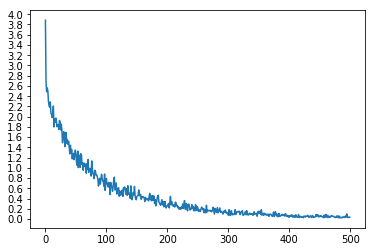

In [54]:
trainIters(encoder1, decoder1, 50000, print_every=1000)

In [150]:
evaluateRandomly(encoder1, decoder1)

> ['.', 'i', 'stunned', 'm', 'm stunned', 'i m', 'stunned .']
= i m stunned .
< i m stunned . <EOS>

> ['nuts', 'you', 're', '!', 're nuts', 'you re', 'nuts !']
= you re nuts !
< you re nuts ! <EOS>

> ['.', 'chubby', 'i', 'm', 'chubby .', 'm chubby', 'i m']
= i m chubby .
< i m chubby . <EOS>

> ['.', 'i', 'concerned', 'm', 'i m', 'concerned .', 'm concerned']
= i m concerned .
< i m concerned . <EOS>

> ['working', 'here', '.', 'm', 'i', 'working here', 'here .', 'i m', 'm working']
= i m working here .
< i m working here . <EOS>

> ['the', '.', 'm', 'calling', 'cops', 'i', 'm calling', 'i m', 'cops .', 'the cops', 'calling the']
= i m calling the cops .
< i m calling the cops . <EOS>

> ['happy', 're', 'all', '.', 'you', 'happy .', 're all', 'you re', 'all happy']
= you re all happy .
< you re all happy . <EOS>

> ['.', 'thinking', 'i', 'm', 'm thinking', 'i m', 'thinking .']
= i m thinking .
< i m thinking . <EOS>

> ['bad', 'you', 're', '.', 're bad', 'you re', 'bad .']
= you re b

In [57]:
def ngram_extractor(sent, order=ORDER):
    ngrams = []
    
    # tokenization
    uwords = [t.text for t in nlp(str(sent))]
    
    # extract ngrams
    for oo in range(1, order + 1):
        for ng in set([' '.join(t).strip() for t in zip(*[uwords[i:] for i in range(oo)])]):
            ngrams.append(ng)
            
    return ngrams

output_words = evaluate(encoder1, decoder1, ngram_extractor("i m hungry"))
output_sentence = ' '.join(output_words)
print(output_sentence)

output_words = evaluate(encoder1, decoder1, ngram_extractor("we run the input sentence through the encoder ."))
output_sentence = ' '.join(output_words)
print(output_sentence)

output_words = evaluate(encoder1, decoder1, ngram_extractor("they re running fast ."))
output_sentence = ' '.join(output_words)
print(output_sentence)

output_words = evaluate(encoder1, decoder1, ngram_extractor("they re winning the game."))
output_sentence = ' '.join(output_words)
print(output_sentence)

i m hungry . <EOS>
we re the married . <EOS>
they re running . <EOS>
they re the . <EOS>


In [58]:
#extract as list, not set
def ngram_extractor_eval(sent, order=1):
    ngrams = []
    
    # tokenization
    uwords = [t.text for t in nlp(str(sent))]
    
    # extract ngrams
    for oo in range(1, order + 1):
        for ng in ([' '.join(t).strip() for t in zip(*[uwords[i:] for i in range(oo)])]):
            ngrams.append(ng)
            
    return ngrams


#ROUGE Score, match/reference length
def ROUGE(cand, ref, n=ORDER):
    cand_ngrams = ngram_extractor_eval(cand, n)
    ref_ngrams = ngram_extractor_eval(ref, n)
    count = 0
    for gram in ref_ngrams:
        if gram in cand_ngrams:
            count += 1
    return count/len(cand_ngrams)

#BLEU Score, match/candidate length, without clipping
def BLEU(cand, ref, n=ORDER):
    cand_ngrams = ngram_extractor_eval(cand, n)
    ref_ngrams = ngram_extractor_eval(ref, n)
    count = 0
    for gram in cand_ngrams:
        if gram in ref_ngrams:
            count += 1
    return count/len(ref_ngrams)

def BLEU_clip(cand, ref, n=ORDER):
    cand_ngrams = ngram_extractor_eval(cand, n)
    ref_ngrams = ngram_extractor_eval(ref, n)
    l = len(ref_ngrams)
    count = 0
    for gram in cand_ngrams:
        if gram in ref_ngrams:
            count += 1
            ref_ngrams.remove(gram)
    return count/l

#Coherence score is used for paragraphs, not used yet
def Coherence():
    pass

def score(list_cand, list_ref, n=ORDER, method='ROUGE'):
    score = 0
    dic = {'ROUGE':ROUGE, 'BLEU':BLEU, 'BLEU_clip':BLEU_clip}
    fun = dic[method]
    num_sent = len(list_cand)
    for i in range(num_sent):
        score += fun(list_cand[i], list_ref[i], n)
    return score/num_sent

In [59]:
def evaluateRandomlyWithScore(encoder, decoder, n=10, method="ROUGE"):
    list_cand = []
    list_ref = []
    for i in range(n):
        pair = random.choice(test_set)
        print('>', pair[0])
        print('=', pair[1])
        output_words = evaluate(encoder, decoder, pair[0])
#         output_words = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')
        list_cand.append(output_sentence)
        list_ref.append(pair[1] + " <EOS>")
    print(score(list_cand, list_ref, method=method))

In [379]:
evaluateRandomlyWithScore(encoder1, decoder1)

> ['he', 'asleep', 'sound', '.', 's', 'sound asleep', 's sound', 'he s', 'asleep .']
= he s sound asleep .
< he s sound asleep . <EOS>

> ['.', 'm', 'i', 'satisfied', 'not', 'not satisfied', 'satisfied .', 'i m', 'm not']
= i m not satisfied .
< i m not satisfied . <EOS>

> ['you', 're', '.', 'reliable', 're reliable', 'you re', 'reliable .']
= you re reliable .
< you re reliable . <EOS>

> ['he', 'asleep', 'sound', '.', 's', 'sound asleep', 's sound', 'he s', 'asleep .']
= he s sound asleep .
< he s sound asleep . <EOS>

> ['exam', 'the', '.', 'm', 'i', 'dreading', 'dreading the', 'i m', 'm dreading', 'exam .', 'the exam']
= i m dreading the exam .
< i m dreading the exam . <EOS>

> ['.', 'm', 'i', 'a', 'psychic', 'not', 'not a', 'i m', 'psychic .', 'a psychic', 'm not']
= i m not a psychic .
< i m not a psychic . <EOS>

> ['exhausted', 'so', 'i', 'am', '!', 'so exhausted', 'exhausted !', 'am so', 'i am']
= i am so exhausted !
< i am so exhausted ! <EOS>

> ['tough', '.', 'i', 'm', 'm

In [63]:
def evaluateDatasetWithScore(encoder, decoder, method="ROUGE"):
    list_cand = []
    list_ref = []
    for i in range(len(test_set)):
        pair = test_set[i]
        print('>', pair[0])
        print('=', pair[1])
        output_words = evaluate(encoder, decoder, pair[0])
#         output_words = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')
        list_cand.append(output_sentence)
        list_ref.append(pair[1] + " <EOS>")
    return score(list_cand, list_ref, method=method)

In [64]:
print("Test score using ROGUE: ", evaluateDatasetWithScore(encoder1, decoder1))

> ['absolutely', '.', 'right', 'are', 'you', 'are absolutely', 'absolutely right', 'you are', 'right .']
= you are absolutely right .
< you are absolutely right . <EOS>

> ['re', 'schedule', '.', 'we', 'behind', 'behind schedule', 'we re', 're behind', 'schedule .']
= we re behind schedule .
< we re really . <EOS>

> ['already', '.', 'm', 'i', 'married', 'married .', 'i m', 'm already', 'already married']
= i m already married .
< i m already married . <EOS>

> ['re', 'you', '.', 'smart', 'very', 'very smart', 'smart .', 'you re', 're very']
= you re very smart .
< you re very smart . <EOS>

> ['timid', 're', 'you', '.', 'very', 'you re', 'timid .', 'very timid', 're very']
= you re very timid .
< you re very timid . <EOS>

> ['he', 'traveling', 'to', '.', 's', 'accustomed', 'to traveling', 'traveling .', 'accustomed to', 's accustomed', 'he s']
= he s accustomed to traveling .
< he s buying to . <EOS>

> ['.', 'm', 'i', 'still', 'married', 'm still', 'still married', 'i m', 'married .

< we are a family . <EOS>

> ['happy', 'more', 'than', '.', 'm', 'i', 'more than', 'm more', 'happy .', 'i m', 'than happy']
= i m more than happy .
< i m more than happy . <EOS>

> ['are', 'you', 'early', '.', 'early .', 'you are', 'are early']
= you are early .
< you are early . <EOS>

> ['.', 'm', 'racist', 'i', 'not', 'not racist', 'i m', 'm not', 'racist .']
= i m not racist .
< i m not late . <EOS>

> ['resourceful', '.', 'i', 'm', 'resourceful .', 'i m', 'm resourceful']
= i m resourceful .
< i m correct . <EOS>

> ['stubborn', 're', '.', 'we', 'we re', 're stubborn', 'stubborn .']
= we re stubborn .
< we re stubborn . <EOS>

> ['re', 'stylish', 'you', '.', 'very', 'stylish .', 'very stylish', 'you re', 're very']
= you re very stylish .
< you re very stylish . <EOS>

> ['anymore', '.', 'm', 'i', 'married', 'not', 'anymore .', 'i m', 'not married', 'married anymore', 'm not']
= i m not married anymore .
< i m not married anymore . <EOS>

> ['re', 'guy', '.', 'wonderful', 'a', 'y

< we re done talking . <EOS>

> ['young', 'he', '.', 'is', 'is young', 'young .', 'he is']
= he is young .
< he is young . <EOS>

> ['all', '.', 'we', 'eleven', 'are', 'in', 'eleven in', 'are eleven', 'all .', 'we are', 'in all']
= we are eleven in all .
< we are all men . <EOS>

> ['re', 'weak', 'too', '.', 'we', 'too weak', 'we re', 're too', 'weak .']
= we re too weak .
< we re too weak . <EOS>

> ['.', 'awfully', 'm', 'i', 'tired', 'awfully tired', 'm awfully', 'i m', 'tired .']
= i m awfully tired .
< i m awfully tired . <EOS>

> ['.', 'daughters', 'are', 'you', 'her', 'daughters .', 'are her', 'you are', 'her daughters']
= you are her daughters .
< you are her her . <EOS>

> ['re', 'now', '.', 'we', 'friends', 'now .', 'we re', 're friends', 'friends now']
= we re friends now .
< we re friends now . <EOS>

> ['.', 'm', 'strong', 'i', 'not', 'strong .', 'i m', 'm not', 'not strong']
= i m not strong .
< i m not strong . <EOS>

> ['friend', 'my', 'best', '.', 'are', 'you', 'you are

< i m greedy . <EOS>

> ['re', 'here', '.', 'we', 'done', 'here .', 'we re', 'done here', 're done']
= we re done here .
< we re here here . <EOS>

> ['he', '.', 'something', 'mumbling', 's', 's mumbling', 'mumbling something', 'something .', 'he s']
= he s mumbling something .
< he s from your . <EOS>

> ['impressed', '.', 'm', 'i', 'very', 'm very', 'impressed .', 'i m', 'very impressed']
= i m very impressed .
< i m very impressed . <EOS>

> ['you', 're', '.', 'tough', 're tough', 'you re', 'tough .']
= you re tough .
< you re tough . <EOS>

> ['the', '.', 'we', 'owners', 'are', 'new', 'new owners', 'the new', 'owners .', 'are the', 'we are']
= we are the new owners .
< we are new dogs . <EOS>

> ['.', 'he', 'asleep', 'is', 'is asleep', 'he is', 'asleep .']
= he is asleep .
< he is probably with . <EOS>

> ['you', 're', '.', 'overworked', 'overworked .', 'you re', 're overworked']
= you re overworked .
< you re overworked . <EOS>

> ['.', 's', 'he', 'adorable', 'he s', 's adorable',

< you re very efficient . <EOS>

> ['he', '.', 'angry', 'is', 'very', 'is very', 'very angry', 'he is', 'angry .']
= he is very angry .
< he is very angry . <EOS>

> ['anymore', 'angry', 'm', '.', 'i', 'not', 'anymore .', 'i m', 'not angry', 'angry anymore', 'm not']
= i m not angry anymore .
< i m not serious . <EOS>

> ['he', '.', 's', 'boy', 'a', 'good', 's a', 'good boy', 'boy .', 'a good', 'he s']
= he s a good boy .
< he s a good . <EOS>

> ['cold', '.', 'm', 'i', 'very', 'm very', 'cold .', 'i m', 'very cold']
= i m very cold .
< i m very cold . <EOS>

> ['happy', '.', 'perfectly', 'm', 'i', 'm perfectly', 'perfectly happy', 'i m', 'happy .']
= i m perfectly happy .
< i m perfectly happy . <EOS>

> ['s', '.', 'pregnant', 'she', 's pregnant', 'pregnant .', 'she s']
= she s pregnant .
< she s pregnant . <EOS>

> ['he', '.', 'nasty', 'is', 'nasty .', 'he is', 'is nasty']
= he is nasty .
< he is wearing . <EOS>

> ['.', 'tourist', 'i', 'a', 'am', 'a tourist', 'am a', 'tourist .', 'i

< you re so sweet . <EOS>

> ['.', 'ready', 'i', 'm', 'm ready', 'ready .', 'i m']
= i m ready .
< i m ready . <EOS>

> ['he', '.', 'is', 'energy', 'full', 'of', 'of energy', 'he is', 'full of', 'is full', 'energy .']
= he is full of energy .
< he is bad bad but . <EOS>

> ['re', 'totally', '.', 'ignorant', 'you', 'ignorant .', 'totally ignorant', 'you re', 're totally']
= you re totally ignorant .
< you re totally ignorant . <EOS>

> ['alone', '.', 'we', 'are', 'not', 'are not', 'not alone', 'alone .', 'we are']
= we are not alone .
< we are not alone . <EOS>

> ['.', 'i', 'm', 'retired', 'm retired', 'i m', 'retired .']
= i m retired .
< i m retired . <EOS>

> ['.', 'm', 'cracking', 'i', 'up', 'cracking up', 'm cracking', 'i m', 'up .']
= i m cracking up .
< i m still on . <EOS>

> ['re', '.', 'we', 'not', 'competitors', 'partners', 'partners .', 're competitors', 'we re', 'not partners', 'competitors not']
= we re competitors not partners .
< we re not . <EOS>

> ['farmer', '.', 'm'

## Downstream Task - Sentence Length

### Preparing data

In [292]:
def prepSentLenData(trainset, testset):
    data = []
    newtrain = []
    newtest = []
    
    print("Counting sentence length...")
    for pair in trainset:
        #input_lang.addSentence(pair[0])
        uwords = [t.text for t in nlp(str(pair[1]))]
        newpair = [pair[0], len(uwords)]
        newtrain.append(newpair)
    
    for pair in testset:
        uwords = [t.text for t in nlp(str(pair[1]))]
        newpair = [pair[0], len(uwords)]
        newtest.append(newpair)
        
    return newtrain, newtest

sentLenTrainData, sentLenTestData = prepSentLenData(train_set, test_set)
print(random.choice(sentLenTrainData))
print(random.choice(sentLenTestData))

Counting sentence length...
[['re', 'talking', '.', 'we', 'done', 'we re', 'talking .', 're done', 'done talking'], 5]
[['re', '.', 'we', 'soldiers', 'not', 'soldiers .', 'we re', 're not', 'not soldiers'], 5]


### Define the multi-level perceptron net for sentence length classification

In [380]:
class MLPNet(nn.Module):
    def __init__(self, class_size=6, act='Tanh'):
        super(MLPNet,self).__init__()
        
        self.hids = []
        
        self.fc1 = nn.Linear(100, 64)
        self.tanh = eval('nn.{}'.format(act))()
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, class_size)
        
        self.hid_modules = nn.ModuleList([h[0] for h in self.hids])

        #self.classifier = nn.Linear(options['n_hid'], 2)
        self.criterion = nn.CrossEntropyLoss()
        
    def forward(self, sentEmb):

        h = sentEmb
        h = self.fc1(h)
        h = self.tanh(h)
        h = self.fc2(h)
        h = self.tanh(h)
        h = self.fc3(h)
        
        #z = self.classifier(h)
        m = nn.Softmax(dim=1)
        z = m(h)

        return z


In [381]:
def trainSentLen(net, encoder, train, test, class_size=6, n_epochs = 100, act='Tanh'):

    
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    input_batches = []
    label_batches = []
    plot_losses = []
    start = time.time()

    for epoch in range(1, n_epochs+1):
        print('Starting the {}-th epoch..'.format(epoch))
        permutation = torch.randperm(len(train))
        #print(permutation)
        print_loss_total = 0  # Reset every print_every
        plot_loss_total = 0  # Reset every plot_every
        label_onehot = torch.LongTensor(batch_size, class_size)
        
        for i in range(0,len(train), batch_size):
            
            #print('#', end='')
            
            indices = permutation[i:i+batch_size]
            input_batch = []
            label_batch = []
            
            for j in indices:
                input_variable = variableFromNGramList(vocab_ngrams, train[j][0], ORDER, NUM_WORDS)
                input_length = input_variable.size()[0]
                
                encoder_hidden = encoder.initHidden()
                encoder_outputs = Variable(torch.zeros(MAX_LENGTH*ORDER, encoder.hidden_size))
                encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs
                
                for ei in range(input_length):
                    encoder_output, encoder_hidden = encoder(
                        input_variable[ei], encoder_hidden)
                    encoder_outputs[ei] = encoder_output[0][0]
                input_batch.append(encoder_hidden.view(100))
                label_batch.append(train[j][1] - 3)
                    
            input_batch = torch.stack(input_batch)
            label_batch = torch.LongTensor(label_batch).view(128,1)
            
            label_onehot.zero_()
            label_onehot.scatter_(1, label_batch, 1)
            
            out = net(input_batch).float()
            #print(out)
            loss = net.criterion(out, Variable(torch.max(label_onehot, 1)[1]))
            net.zero_grad()
            loss.backward()
            optimizer.step()
            
            print_loss_total += loss
            plot_loss_total += loss
           
        print_loss_avg = print_loss_total / batch_size
        print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                epoch, epoch / n_epochs * 100, print_loss_avg))

        plot_loss_avg = plot_loss_total / batch_size
        plot_losses.append(plot_loss_avg.data[0])
        plot_loss_total = 0
    
    #print(plot_losses)
    showPlot(plot_losses)

In [382]:
print(len(train_set))

5120


Starting the 1-th epoch..
1m 9s (- 10m 28s) (1 10%) 0.5206
Starting the 2-th epoch..
2m 9s (- 8m 39s) (2 20%) 0.4717
Starting the 3-th epoch..
3m 15s (- 7m 37s) (3 30%) 0.4393
Starting the 4-th epoch..
4m 18s (- 6m 27s) (4 40%) 0.4211
Starting the 5-th epoch..
4m 59s (- 4m 59s) (5 50%) 0.4098
Starting the 6-th epoch..
6m 3s (- 4m 2s) (6 60%) 0.4011
Starting the 7-th epoch..
6m 44s (- 2m 53s) (7 70%) 0.3947
Starting the 8-th epoch..
7m 48s (- 1m 57s) (8 80%) 0.3889
Starting the 9-th epoch..
8m 28s (- 0m 56s) (9 90%) 0.3842
Starting the 10-th epoch..
9m 34s (- 0m 0s) (10 100%) 0.3799


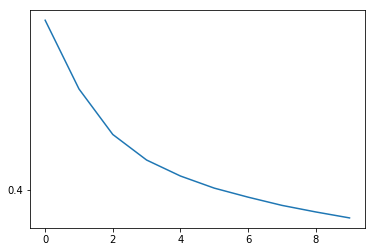

In [383]:
classes = (3, 4, 5, 6, 7, 8)
batch_size = 128
net = MLPNet(len(classes))
trainSentLen(net, encoder1, sentLenTrainData, sentLenTestData , n_epochs=10)

### Sentence Length on test set

In [424]:
def evaluateSentLenTestSet(net, encoder, testset):
    correct = 0
    total = 0
    for pair in testset:
        input_variable = variableFromNGramList(vocab_ngrams, pair[0], ORDER, NUM_WORDS)
        input_length = input_variable.size()[0]
                
        encoder_hidden = encoder.initHidden()
        encoder_outputs = Variable(torch.zeros(MAX_LENGTH*ORDER, encoder.hidden_size))
        encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs
                
        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(
                input_variable[ei], encoder_hidden)
            encoder_outputs[ei] = encoder_output[0][0]
        
        #print(encoder_hidden)
        
        outputs = net(encoder_hidden.view(1,100))
        #print(outputs)
        #print(torch.max(outputs, 1)[1].data[0])
        predict = torch.max(outputs, 1)[1].data[0]
        
        total += 1
        if (predict+3 == pair[1]):
            correct += 1

    print('Accuracy of the network on the sentence length test set: %d %%' % (
        100 * correct / total))

In [425]:
evaluateSentLenTestSet(net, encoder1, sentLenTestData)

Accuracy of the network on the sentence length test set: 75 %


Visualizing Attention
---------------------

A useful property of the attention mechanism is its highly interpretable
outputs. Because it is used to weight specific encoder outputs of the
input sequence, we can imagine looking where the network is focused most
at each time step.

You could simply run ``plt.matshow(attentions)`` to see attention output
displayed as a matrix, with the columns being input steps and rows being
output steps:




In [25]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "je suis trop froid .")
plt.matshow(attentions.numpy())

NameError: name 'attn_decoder1' is not defined

For a better viewing experience we will do the extra work of adding axes
and labels:




In [ ]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("elle a cinq ans de moins que moi .")

evaluateAndShowAttention("elle est trop petit .")

evaluateAndShowAttention("je ne crains pas de mourir .")

evaluateAndShowAttention("c est un jeune directeur plein de talent .")

Exercises
=========

-  Try with a different dataset

   -  Another language pair
   -  Human → Machine (e.g. IOT commands)
   -  Chat → Response
   -  Question → Answer

-  Replace the embeddings with pre-trained word embeddings such as word2vec or
   GloVe
-  Try with more layers, more hidden units, and more sentences. Compare
   the training time and results.
-  If you use a translation file where pairs have two of the same phrase
   (``I am test \t I am test``), you can use this as an autoencoder. Try
   this:

   -  Train as an autoencoder
   -  Save only the Encoder network
   -  Train a new Decoder for translation from there




In [195]:
import torch

batch_size = 5
nb_digits = 10
# Dummy input that HAS to be 2D for the scatter (you can use view(-1,1) if needed)
y = torch.LongTensor(batch_size,1).random_() % nb_digits
# One hot encoding buffer that you create out of the loop and just keep reusing
y_onehot = torch.FloatTensor(batch_size, nb_digits)

# In your for loop
y_onehot.zero_()
y_onehot.scatter_(1, y, 1)

print(y)
print(y_onehot)


 2
 0
 5
 9
 3
[torch.LongTensor of size 5x1]


    0     0     1     0     0     0     0     0     0     0
    1     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     1     0     0     0     0
    0     0     0     0     0     0     0     0     0     1
    0     0     0     1     0     0     0     0     0     0
[torch.FloatTensor of size 5x10]

